# ENEN 645 W2026 Group 4 - Assignment 2

Team members:

Taranvir Hundal UCID: 10151486

Mohammad Defaee UCID: 30265921

Maciek Popik UCID: 30303637

Freya Rezaei UCID: 30296382

Data File download:

https://uofc-my.sharepoint.com/:u:/g/personal/maciek_popik_ucalgary_ca/IQDr4CGfaxWDQJBmznYjCcgMAXQBhIRirENb-DZUjex5Qnc?e=BWfIwZ

(Expiration: 2026-03-04)

Below we import all of the necessary libraries and set up the 'device' to utilize a GPU if avaialble, otherwise, use the CPU

In [24]:
import os, glob, re
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import textwrap
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# Root folder that already contains Train / Val / Test folders
OUTDIR = r"C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data"



cuda:0


The first step is to import the data into the coding environment.
Two appraoches were taken for completing this code. Code was both developed in Google Colab and on a local lab computer with adequate processing power.

To allow Colab use, the data was first downloaded from the TALC cluster and saved in the University of Calgary OneDrive. A shared link was made for this file (by university policy, this link must expire after 7 days of being created), using this link the data is downloaded into colab, the files are extracted and the tar.gz archive is deleted to free up some space on the colab runtime. This process must happen each time the runtime is started.

Using the alterantive method, the same files were downloaded and extracted locally, to the directory specified above. From there, a local Jutpyter Notebook running on VS Code was used to access the data.

In [ ]:

# === Data Import Depending on whether we are in Google Colab or not ====

# Helper function to check if currently running on Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    # === Importing and Extracting Dataset (Colab Version) ===

    # Data has been downloaded from TALC and saved on OneDrive - as per University Policy - link is only good for 1 week - current exipration: 2026-03-04
    DATA_URL = "https://uofc-my.sharepoint.com/personal/maciek_popik_ucalgary_ca/_layouts/15/download.aspx?share=IQDr4CGfaxWDQJBmznYjCcgMAXQBhIRirENb-DZUjex5Qnc"
    ARCHIVE = "garbage_data.tar.gz"
    OUTDIR = "/content/garbage_data"

    # Download & extract only if not already extracted
    if not os.path.isdir(OUTDIR):

        print("Downloading dataset from OneDrive...")
        !wget -q --show-progress "$DATA_URL" -O "$ARCHIVE"

        print("\nExtracting dataset...")
        !tar -xzf "$ARCHIVE" -C /content

        print("Deleting archive...")
        !rm "$ARCHIVE"

        print("Done.")
    else:
        print("Dataset already exists at:", OUTDIR)


else:
    # === Using Local Dataset (already extracted - Lab Computer Version) ===

    if not os.path.isdir(OUTDIR):
        raise FileNotFoundError(f"Dataset folder not found: {OUTDIR}")
    else:
        print("Using local dataset at:", OUTDIR)

    # Define paths for training
    data_dir = OUTDIR

    train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
    val_dir   = os.path.join(data_dir, "CVPR_2024_dataset_Val")
    test_dir  = os.path.join(data_dir, "CVPR_2024_dataset_Test")

    print("Train:", train_dir)
    print("Val:", val_dir)
    print("Test:", test_dir)




# Define paths for training
data_dir = OUTDIR
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir   = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir  = os.path.join(data_dir, "CVPR_2024_dataset_Test")


# Sanity check image count
splits = {
    "CVPR_2024_dataset_Train": train_dir,
    "CVPR_2024_dataset_Val":   val_dir,
    "CVPR_2024_dataset_Test":  test_dir,
}

# Print the directory name, label classes of each directory and number of images in each class
for split_name, split_path in splits.items(): 
    print(f"\n--- {split_name} ---")
    classes = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    total_images = len(glob.glob(os.path.join(split_path, "*", "*.png"))) # Get total image count in each dir
    print("Classes:", classes)
    # Within each directory/set, print out the total number of images per class and how much % this takes up for the set
    # This will help identify imbalance of labels across the 3 sets
    for c in classes:
        n = len(glob.glob(os.path.join(split_path, c, "*.png")))
        print(f"{c}: {n} images - {n/total_images*100:.2f}% of set")

Using local dataset at: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data
Train: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Train
Val: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Val
Test: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Test

--- CVPR_2024_dataset_Train ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 2368 images - 20.36% of set
Blue: 4842 images - 41.64% of set
Green: 2317 images - 19.92% of set
TTR: 2102 images - 18.08% of set

--- CVPR_2024_dataset_Val ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 372 images - 20.67% of set
Blue: 768 images - 42.67% of set
Green: 352 images - 19.56% of set
TTR: 308 images - 17.11% of set

--- CVPR_2024_dataset_Test ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 695 images - 20.25% of set
Blue: 1086 images - 31.64% of set
Green: 799 images - 23.28% of set
TTR: 852 images - 24.83% of set


Note that there is a slight imbalance of labels (Label Drift) from the evaluation set of training and validation into the testing set. The testing set contains an overall smaller percentage of Blue labels and a larger percentage of TTR labels.

Next, we define the transformations that are to be made on each dataset. Each image is 1024x1024 pixels, although in a CNN, the number of parameters does not change with larger or smaller images, the number of computations does. With 1024x1024 pixels, each with 3 channels (RGB), per image, assuming a 3x3 kernel, there are 1024x1024x3x3x3 + 1 = 28,311,553 computations per filter. To reduce the number of computations, and align closer to the size that ResNet50 was trained on (224x224 [1]), images will first be reduced in size by trial and error to determine best performance.

Additionally, several augmentations will be made including altering perpective and scaling the image to simulate excessive zoom, horizontal/vertical flipping to generalize against orientation, random rotations in the range of ±15° simulating instability / misorientation when a photo is taken by a user. Finally, image brightness, contrast and saturation is varied to simulate different environments in which images may have been taken.

Note that augmentations are not performed on the evaluation data (other than size for consitency) as to not alter the images used to evaluate classification performance.

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition*.  
    arXiv:1512.03385. https://arxiv.org/abs/1512.03385

In [26]:
# === Defining Transforms Used on Data ===

# Reduced Image Size
# Stated off with 64 for lighter processing, moved up to 160, finished on 224, matching the same size of
# images that ResNet50 and MobileNet were trained on
IMG_SIZE = 224

# Below are the transforms used for the development dataset (include augmentation)
# The aim with these is to replicate the variances that might be present when someone is taking pictures
# of garbage to use such a program (ie. positional variations, vertical and horizontal flips following that
# most garbage does not really have an 'oriantation', and rotational, zoom and colour scews to replicate
# variations in the environment where such images might be taken)
transform = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),                    # resize to smaller specified size
        #transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),   # random crop/zoom
        transforms.RandomHorizontalFlip(p=0.5),                     # flip horizontally
        transforms.RandomVerticalFlip(p=0.2),                       # flip vertically
        transforms.RandomAffine(                                    # Random rotations, tranlations and scaling     
            degrees=15,
            translate=(0.05, 0.05),
            scale=(0.9, 1.1)
        ),
        transforms.RandomPerspective(distortion_scale=0.15, p=0.1),               # Random perspective
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),  # Variation in lighting
        transforms.ToTensor(),                                      # PIL -> torch tensor [0,1]
        transforms.Normalize(                                       # use ImageNet stats for pretrained ResNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ]),

    # For evaluation, we only apply the same size and stats changes that the model was trained on
    "eval": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
}


Next we create the datasets. Given that we are using both images and file names, several considerations must be taken into place. First, the file names are pre-processed to eliminate exentions and directories from their names and to replace underscores and dashes with spaces. Additoinally, trailing numbers, multiple, leading and trailing spaces are also removed.

Next, normally we would use ImageFolder to return the images and labels of shape (image, label), but now there is text to return too, so a subclass is made, ImageTextFolder, that returns (image, text, label). 

Using this assisting function and class, the datasets are created.

Finally, we also determine class weights due to the label imbalance that will be used to penalize misclassification of underrepresented classes more heavily than those with more data at the loss function.

In [27]:
# === Creation of datasets ===

# Funciton for cleaning up file names
def filename_to_text(path: str) -> str:
    name = os.path.splitext(os.path.basename(path))[0]  # remove extension and dir
    name = re.sub(r"[_\-]+", " ", name)                 # Replace _ and - with spaces
    name = re.sub(r"_\d+$", "", name)                   # remove trailing numbers
    name = re.sub(r"\s+", " ", name).strip()            # remove multiple/trailing/leading spaces
    return name

# subclass of torchvision.datasets.ImageFolder to return:
# (image, text, label) in place of: (image, label)
class ImageTextFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index) # Get image and label as normal
        path, _ = self.samples[index] # retreive path with name
        text = filename_to_text(path)  # apply above function to clean name
        return image, text, label # Return image, name, and label


# Each dataset is made using the previously defined directory and associated transform
# === Creation of datasets ===
image_datasets = {
    "train": ImageTextFolder(train_dir, transform=transform["train"]),
    "val":   ImageTextFolder(val_dir,   transform=transform["eval"]),
    "test":  ImageTextFolder(test_dir,  transform=transform["eval"])
}

# --- class weights from training set ---
# Based on the slight imbalance of classes above, we will define class weight to penalize
# classes with less samples more than classes with more samples
train_labels = [lbl for _, lbl in image_datasets["train"].samples] # Get list of all labels
counts = np.bincount(train_labels, minlength=len(image_datasets["train"].classes)) # Count label occurances
weights = 1.0 / np.clip(counts, 1, None) # Take the inverse of the weights, clipping 0s for min value of 1
weights = weights / weights.sum() * len(weights)  # normalize weights

class_weights = torch.tensor(weights, dtype=torch.float32, device=device) # Convert numpy weight array to tensor



Next, we define the data loaders. Because each sample contains both an image tensor and a filename-derived text string, custom batching is required. A DistilBERT tokenizer is instantiated to convert the text strings into token IDs and attention masks, and a custom collate_fn is used to stack image tensors, convert labels to tensors, and tokenize/pad the text inputs so all batch elements have consistent tensor shapes.

In [28]:
# NOTE (Windows): DataLoader multiprocessing can hang when num_workers > 0.
# Windows uses the "spawn" start method (unlike Linux "fork"), so each worker launches a fresh
# Python interpreter and re-imports the main module. In VS Code / notebook-style execution,
# this can cause deadlocks or repeated re-execution of top-level code. Setting num_workers=0 forces
# data loading to run in the main process and avoids these Windows spawn issues. This has been done 
# for the local computer (running Windows), however the number of workers can be set > 0 for Colab 
# or other Linux environments

# === Creation of data loaders ===
BATCH_SIZE = 128
NUM_WORKERS = 0 # Set to 0 for Windows machine to avoid multiprocessing errors

# Setup tokenizer to convert filename-derived text into token IDs for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Defining custom batching function
def collate_fn(batch):
    images, texts, labels = zip(*batch) # Unzip batch list
    images = torch.stack(images) # rearange structure from (3, IMG_SIZE, IMG_SIZE) to (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), stacking per-sample image tensors into a batch
    labels = torch.tensor(labels) # Convert the labels from a list to a tensor, shape: (BATCH_SIZE,)

    enc = tokenizer(
        list(texts),  # Convert 'texts' from tuple to list
        padding=True, # Add padding so that all labels of a batch are same length
        truncation=True,  # Truncate long text sequences to max_length tokens
        max_length=32,
        return_tensors="pt" # Retrn type set to PyTorch tensor
    )
    # Now that shapes are corrected, return as model expects them
    return images, enc, labels

# Define data loaders for each dataset, using the defined collate_fn
# Note that training DataLoader is shuffled for variation between epochs, val and test are not for consistency
dataLoaders = {
    "train": DataLoader(image_datasets["train"], batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
    "val":   DataLoader(image_datasets["val"], batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
    "test":  DataLoader(image_datasets["test"], batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
}


# Checking batch shape by iterating through the train DataLoader
images, enc, labels = next(iter(dataLoaders["train"]))

print("Batch image tensor shape:", images.shape)          # (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
print("Batch input_ids shape:", enc["input_ids"].shape)   # (BATCH_SIZE, sequence_length)
print("Batch attention_mask shape:", enc["attention_mask"].shape)
print("Batch labels shape:", labels.shape)            # (BATCH_SIZE,)
print("Labels example:", labels[:10].tolist())


Batch image tensor shape: torch.Size([128, 3, 224, 224])
Batch input_ids shape: torch.Size([128, 12])
Batch attention_mask shape: torch.Size([128, 12])
Batch labels shape: torch.Size([128])
Labels example: [1, 3, 1, 1, 1, 1, 1, 2, 3, 0]


Now we build the multimodal model. The architecture combines three main components: (1) a pretrained CNN backbone (ResNet50 in the final configuration, MobileNetV2 also attempted) for image feature extraction, (2) a pretrained DistilBERT encoder for filename-derived text features, and (3) a user-defined multi-layer perceptron (MLP) classifier head.

The CNN’s final classification layer is removed so that the 2048-dimensional image feature vector can be used for fusion. For the text branch, DistilBERT produces contextual token embeddings which are aggregated into a single fixed-length vector via masked mean pooling. Because filenames are short and structured, the resulting 768-dimensional text feature is projected to a smaller 512-dimensional bottleneck to reduce model capacity and improve generalization. Finally, image and text features are layer-normalized, concatenated, and passed through the MLP head to output class logits.

In [29]:
# === Building Model - ResNet + DistilBERT + Fusion Head ===

# Helper function to build a variable-depth MLP, utilizing nn.Linear, ReLU activation and specified dropout
def make_mlp(in_dim, hidden_dims, out_dim, dropout=0.2):
    '''
    in_dim: input feature dimension
    hidden_dims: expected as list like [512, 256, 128], number of neurons at each element
    out_dim: number of classes
    dropout: specify percentage dropout for regularization
    '''

    layers = []
    prev = in_dim
    # Build each layer as an iteration using previous layer's output size as current layer's input size
    for h in hidden_dims:
        layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
        prev = h
    layers += [nn.Linear(prev, out_dim)]
    return nn.Sequential(*layers)


# Define new neural network class, inheriting from nn.Module
class MultiModalNet(nn.Module):
    def __init__(self, num_classes, hidden_dims=[512, 128], dropout=0.2):
        super().__init__()

        # Vision encoder (ResNet50 -> 2048 feat)
        self.vision = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # Build .vision as loaded, pretrained ResNet
        vision_dim = self.vision.fc.in_features # Extract the number of input features from final ResNet classification layer
        self.vision.fc = nn.Identity() # Remove classifier so ResNet outputs 2048-d features

        # Text encoder (DistilBERT -> 768 feat)
        self.text = AutoModel.from_pretrained("distilbert-base-uncased") # Load in DistilBERT encoder
        text_dim = 768 # Define the feature size from DistilBERT (768)

        text_project_size = 512 # Final text layer projection size

        # Normalize/project features before fusion
        self.vision_norm = nn.LayerNorm(vision_dim) # Layer-normalize image features before fusion
        # Due to file names being relatively short in length, we can reduce the output feature size for text
        # by trial and error, reduce final feature dimension from 768 to 512
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, text_project_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.text_norm = nn.LayerNorm(text_project_size) # Normalize text layer

        # Vision and text will be concatenated prior to entering final fusion head classifier

        # Fusion head (input size is now 2048 + text_project_size given concatenation)
        self.head = make_mlp(vision_dim + text_project_size, hidden_dims, num_classes, dropout)

    # Defining forward pass, where images is image batch tensor, enc is the tokenizer output dict
    def forward(self, images, enc):
        img_feat = self.vision(images)  # (BATCH_SIZE, 2048) - Images go through image model with fc removed

        # Force text tensors to the same device as images
        input_ids = enc["input_ids"].to(images.device)
        attention_mask = enc["attention_mask"].to(images.device)

        txt_out = self.text(input_ids=input_ids, attention_mask=attention_mask) # Token IDs and masks into DistilBERT
        last = txt_out.last_hidden_state                       # (BATCH_SIZE, sequence_length, 768) - embedded DistilBERT output
        mask = attention_mask.unsqueeze(-1).float()            # (BATCH_SIZE, sequence_length, 1)
        # Masked mean pooling
        txt_feat = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)  # (BATCH_SIZE, 768)

        img_feat = self.vision_norm(img_feat) # Normalize Image Features
        txt_feat = self.text_proj(txt_feat) # Project Text Features - (BATCH_SIZE, 768) -> (BATCH_SIZE, text_project_size)
        txt_feat = self.text_norm(txt_feat) # Normalize Text Features

        fused = torch.cat([img_feat, txt_feat], dim=1) # Concatenate along feature dimension
        return self.head(fused) # Return logit outputs from MLP classifier

num_classes = len(image_datasets["train"].classes) # Number of classes extracted from train set
hidden_dims = [512, 256, 128] # User Defined defined MLP classifier

# Construction of model
model = MultiModalNet(num_classes=num_classes, hidden_dims=hidden_dims, dropout=0.3).to(device)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Next, we prepare for training. Training occurs in two phases:

Phase 1: Pretrained CNN + DistilBERT Encoder weights are frozen, only classifier is trained with relatively high learning rate

Phase 2: All weights are unfrozen and fine-tuning is applied using a very small learning rate over just a few epochs. Learning rates vary across model sections; the classifier maintains a higher learning rate, ResNet50 has a medium sized learning rate, and the heavier DistilBERT has the smallest learning rate.

Note that we did also attempt to only unfreeze the final layers of each model, leaving majority of each model frozen, however this was found to have little effect on the final accuracy.


Below, we prepare for phase 1, freezing all weight but those associated to the classifier, and defining the optimizer to be used: AdamW

In [30]:
# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the fusion head
for p in model.head.parameters():
    p.requires_grad = True

# Define optimizer
optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-2)

The below block takes on three sections as outlined below:

1. Config: Here, the user specifies whether to learn weights from scratch or load existing weights. During completion of each of the 2 training phases, weights are saved. If for example hyperparameters are changed only in the fine tuning stage, or if training crashes in the fine tuning stage, the saved "Head Checkpoint" may be loaded in as a starting point. The file names and paths for these saved checkpoints; Head and Fine Tuning are specified here too. Finally, the loss function is specified before training begins, making use of the previosuly defined class weights.

2. Helpers: Here, a function for enabling / disabling gradients is defined alongside the main training function.
The main training function makes use of a scheduler to reduce the learning rate when validation checks do not result in improvements, early exiting is used to finish training early when a specified number of epochs result in no impovement, and training / validation loss and accuracy is logged along the way for plotting later.

3. Main Logic: This section defines whether the model will learn from scratch or from a previously defined checkpoint. This is the main logic for loading in weights and coordinating between phase 1 and 2 training, loading in the best validation accuracy results between phases

In [31]:
# =========================
# CONFIG
# =========================

# User defined varaible for either loading in previosuly trained weights where saved, or training from scratch
load_existing_weights = True

# File names and locations for saved weights
HEAD_CKPT = "./mm_head_only.pth" # Save file for Training Phase 1: Classifier Head Training Only
FT_CKPT   = "./mm_finetuned.pth" # Save file for Training Phase 2: Fine Tuning of full model

# Define loss function as cross-entropy loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)


# =========================
# HELPERS
# =========================

# Helper function for enabling / disabling gradients for a given model module
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

# Function for main training loop
def train_phase(model, dataLoaders, optimizer, nepochs, save_path):
    """
    model: Provide constructed model used for training
    dataLoaders: Provide defined training and validation dataLoaders
    optimizer: Provide specified optimizer
    nepochs: Specify number of epochs for training
    save_path: specify directory for save files
    """
    # Initialization of counters / accumulators
    best_acc = 0.0 # Initialize current best accuracy as 0
    best_val_loss = float("inf") # Initialize current best loss as infinity
    patience = 3 # Specify patience for early exiting (3 consecutive epochs with no val check improvement in loss)
    patience_ctr = 0 # Initialize patience counter at 0

    # Define scheduler to vary Learning Rate (LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,  # Apply to optimizer
        mode="min", # Reduce LR when applied
        factor=0.5, # Reduced LR by half when triggered
        patience=1  # If loss fails to improve for 1 check, reduce LR
    )

    # Initialize per-epoch metrics for plotting later
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Main Training Loop
    for epoch in range(nepochs): # Outer loop over epochs
        print(f"Epoch {epoch + 1}/{nepochs}")

        for phase in ["train", "val"]:
            # For each epoch, alternate between training and validation, switching model to train / eval mode
            model.train() if phase == "train" else model.eval()

            # Counters / accumulators for various metrics
            running_loss = 0.0 # Total loss over all samples
            running_corrects = 0 # Total number of correct predictions
            n_samples = 0 # Total number of samples

            # Iteration over batches (i starts at 1)
            for i, (inputs, enc, labels) in enumerate(dataLoaders[phase], 1):
                # Move images to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Clear gradients from previous batch
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"): # Enables gradients during training, not validation
                    outputs = model(inputs, enc)      # Perform forward pass
                    loss = criterion(outputs, labels) # Calculate loss
                    preds = outputs.argmax(dim=1)     # Predict class index per sample

                    if phase == "train": # Only during training
                        loss.backward()  # Compute gradients via back propagate
                        optimizer.step() # Update trainable parameters

                bs = inputs.size(0) # Get current batch size (last batch could be smaller than BATCH_SIZE)
                running_loss += loss.item() * bs # Running loss is average loss * batch size
                running_corrects += (preds == labels).sum().item() # Add number of correct predictions from batch
                n_samples += bs # Add to the total number samples by batch size

                # Print out for training progress, specifying current epoch, batch and estimated training loss 
                if phase == "train" and (i == 1 or i % 25 == 0):
                    print(f"epoch {epoch+1} batch {i}, current loss: {running_loss/n_samples:.4f}", flush=True)

            epoch_loss = running_loss / n_samples       # Average loss of all samples in current epoch for current phase
            epoch_acc  = running_corrects / n_samples   # Average accuracy for all samples in current epoch for current phase
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}") # Print epoch phase results
            
            # Append to training / validation list for plotting later
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                # step scheduler on val loss to potentially vary learning rate
                # Note: saving is based on epoch accuracy, scheduler is based on loss. 
                # Loss is used here as it is generally more gradual and stable in change 
                # and a better metric for consecutive counts
                scheduler.step(epoch_loss)

                # early stopping on val loss
                if epoch_loss < best_val_loss - 1e-4:
                    best_val_loss = epoch_loss
                    patience_ctr = 0
                else:
                    patience_ctr += 1
                    if patience_ctr >= patience:
                        print(f"Early stopping: val loss not improving for {patience} epochs.")
                        return {
                            "train_losses": train_losses,
                            "val_losses": val_losses,
                            "train_accs": train_accs,
                            "val_accs": val_accs,
                            "best_acc": best_acc
                        }

                # save best by val accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    print("Saving best model:", save_path)
                    torch.save({
                        "model": model.state_dict(),
                        "best_acc": best_acc,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                        "train_accs": train_accs,
                        "val_accs": val_accs,
                    }, save_path)

    print(f"Best val Acc: {best_acc:.4f}")
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_acc": best_acc
    }
    return history


# =========================
# MAIN LOGIC
# =========================

# Always define hist1/hist2 so plotting works whether we TRAIN or LOAD.
# (If we load a single combined history from FT_CKPT, we’ll store it in hist1 and leave hist2 empty.)
hist1 = {"train_losses": [], "val_losses": [], "train_accs": [], "val_accs": []}
hist2 = {"train_losses": [], "val_losses": [], "train_accs": [], "val_accs": []}

# ===== If NOT training and full training was done before and weights were saved =====
if load_existing_weights and os.path.exists(FT_CKPT):
    # -------- Load fine-tuned model (preferred) --------
    ckpt = torch.load(FT_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)
    
    # Load Phase 2 history from FT_CKPT (if present)
    c2 = torch.load(FT_CKPT, map_location="cpu")
    if "train_losses" in c2:
        hist2["train_losses"] = c2["train_losses"]
        hist2["val_losses"]   = c2["val_losses"]
        hist2["train_accs"]   = c2["train_accs"]
        hist2["val_accs"]     = c2["val_accs"]

    # Load Phase 1 history from HEAD_CKPT if it exists (for train / validation curve reconstruction)
    if os.path.exists(HEAD_CKPT):
        c1 = torch.load(HEAD_CKPT, map_location="cpu")
        if "train_losses" in c1:
            hist1["train_losses"] = c1["train_losses"]
            hist1["val_losses"]   = c1["val_losses"]
            hist1["train_accs"]   = c1["train_accs"]
            hist1["val_accs"]     = c1["val_accs"]

    print("Loaded fine-tuned weights from:", FT_CKPT)

# ===== If NOT training and only fusion head weights saved =====
elif load_existing_weights and os.path.exists(HEAD_CKPT):
    # -------- Load head-only model (fallback) --------
    # This condition loads Phase 1 if finished earlier, and allows Phase 2 to complete.
    ckpt = torch.load(HEAD_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)

    c1 = torch.load(HEAD_CKPT, map_location="cpu")
    if "train_losses" in c1:
        hist1["train_losses"] = c1["train_losses"]
        hist1["val_losses"]   = c1["val_losses"]
        hist1["train_accs"]   = c1["train_accs"]
        hist1["val_accs"]     = c1["val_accs"]

    print("Loaded head-only weights from:", HEAD_CKPT)
    # -------- Phase 2: Fine-tune specified models --------
    print("\n=== Phase 2: Fine-tune Specified Models ===")
    set_requires_grad(model.vision, True)
    set_requires_grad(model.text,   True)
    set_requires_grad(model.head,   True)

    # Smallest LR for heavy DistilBERT, slightly higher for ResNet and highest for head
    optimizer = torch.optim.AdamW([
        {"params": model.text.parameters(),   "lr": 1e-6},
        {"params": model.vision.parameters(), "lr": 1e-5},
        {"params": model.head.parameters(),   "lr": 3e-5},
    ], weight_decay=1e-2)

    # hist2 contains Phase 2 history (loss/acc curves)
    hist2 = train_phase(model, dataLoaders, optimizer, nepochs=4, save_path=FT_CKPT)

    print("\nFinished Fine-tuning")
    print("Saved fine-tuned checkpoint:", FT_CKPT)



# ===== FULL TRAINING =====
else:
    # -------- Phase 1: Train head only (freeze ResNet + DistilBERT) --------
    # Goal: quickly fit the fusion head while keeping both backbones fixed.
    print("\n=== Phase 1: Train fusion head only ===")
    set_requires_grad(model.vision, False)
    set_requires_grad(model.text,   False)
    set_requires_grad(model.head,   True)

    optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-2)

    # hist1 contains Phase 1 history (loss/acc curves)
    hist1 = train_phase(model, dataLoaders, optimizer, nepochs=10, save_path=HEAD_CKPT)

    # Load best head-only weights before fine-tuning (final epoch may not be the best one in terms of validation accuracy)
    ckpt = torch.load(HEAD_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)

    # -------- Phase 2: Fine-tune ResNet & DistilBEST + head (very low LR) --------
    # Goal: unfreeze ResNet & DistilBERT to squeeze out extra performance, but keep LR tiny to avoid wrecking pretrained features.
    print("\n=== Phase 2: Fine-tune Specified Models ===")
    set_requires_grad(model.vision, True)
    set_requires_grad(model.text,   True)
    set_requires_grad(model.head,   True)

    # Smallest LR for heavy DistilBERT, slightly higher for ResNet and highest for head
    optimizer = torch.optim.AdamW([
        {"params": model.text.parameters(), "lr": 1e-6},
        {"params": model.vision.parameters(), "lr": 1e-5},
        {"params": model.head.parameters(),   "lr": 3e-5},
    ], weight_decay=1e-2)

    # hist2 contains Phase 2 history (loss/acc curves)
    hist2 = train_phase(model, dataLoaders, optimizer, nepochs=4, save_path=FT_CKPT)


    print("\nFinished Training")
    print("Saved head-only checkpoint:", HEAD_CKPT)
    print("Saved fine-tuned checkpoint:", FT_CKPT)

Loaded fine-tuned weights from: ./mm_finetuned.pth


Once training is complete, the first thing that we do is plot the training vs. validation results to get a sense of whether or not we are overfitting.

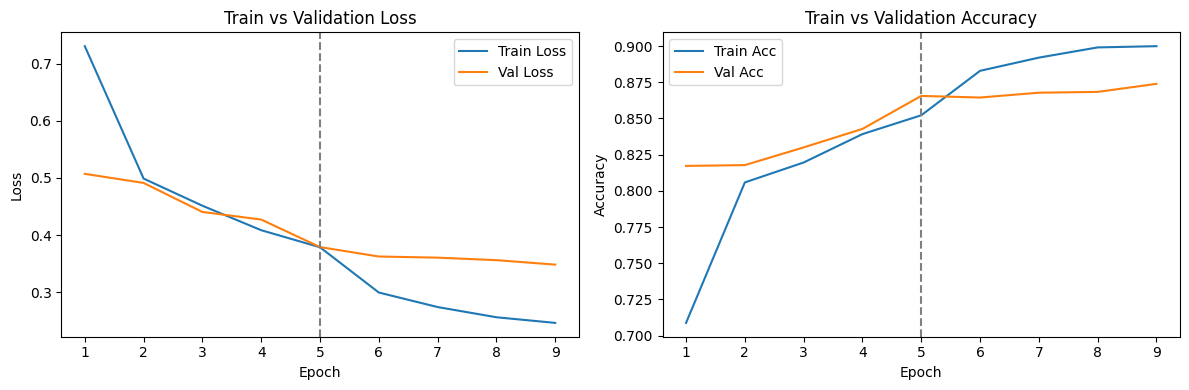

In [32]:
# === Training vs. Validation Spec Visualization ===

# Combine phase 1 and phase 2 histories
train_losses = hist1["train_losses"] + hist2["train_losses"]
val_losses   = hist1["val_losses"]   + hist2["val_losses"]
train_accs   = hist1["train_accs"]   + hist2["train_accs"]
val_accs     = hist1["val_accs"]     + hist2["val_accs"]

epochs = range(1, len(train_losses) + 1) # Total number of epochs for head training + fine tuning

plt.figure(figsize=(12, 4))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.axvline(x=len(hist1["train_losses"]), linestyle="--", color="gray")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.axvline(x=len(hist1["train_accs"]), linestyle="--", color="gray")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


From the plots, it is apparent that the training loss / accuracy continues to improve as we begin to overfit to the data, however the validation set seems to plateau, but not yet overfit. Overall, this seems to suggest that we are at the limits of what we can do with regard to training, but may further benefit from better generalization.

Note that the head classifier and finetuning epochs are stacked here depending on whether early exiting was used or not, it may not be obvious when the model tranitioned into fine tuning, hence a dashed grey vertical line is used to separate head-only training and fine tuning.

Next, we run the testing loop to check how our model performs against data that it has not yet seen.

After training, the best-performing checkpoint (based on validation accuracy) is automatically selected and loaded. The model is then evaluated on the test dataset, which contains samples not used during training or validation. During testing, gradients are disabled to reduce memory usage and improve efficiency. Predictions are collected for computing metrics, and misclassified examples are stored for qualitative error analysis.

Along the way, we store the sample labels and predictions alongside some examples of correct classifications and incorrect classifications to display later (important that we do not shuffle the Test set loader for this). We limit the number of samples from each class to ensure a uniform distribution over classes (prior to doing this, nearly all examples were from the Black class).

In [ ]:
# === Testing Loop ===

# --- Helper Function for Best Model ---
def pick_best_ckpt(head_ckpt, ft_ckpt):
    best_path = None
    best_acc = -1.0

    # check head ckpt
    # Recall that checkpoints were saved based on best accuracy, not final epoch
    if os.path.exists(head_ckpt):
        c = torch.load(head_ckpt, map_location="cpu") # If head classifier checkpoint exists, load it in
        acc = float(c.get("best_acc", c.get("best_val_acc", -1.0)))
        if acc > best_acc:
            best_acc = acc
            best_path = head_ckpt

    # check fine-tuned ckpt
    if os.path.exists(ft_ckpt):
        c = torch.load(ft_ckpt, map_location="cpu") # If fine tuning checkpoint exists, load it in
        acc = float(c.get("best_acc", c.get("best_val_acc", -1.0)))
        if acc > best_acc:
            best_acc = acc
            best_path = ft_ckpt

    if best_path is None:
        raise FileNotFoundError("No checkpoint found (neither HEAD nor FT).")

    return best_path, best_acc

# --- load best model ---
PATH, best_acc = pick_best_ckpt(HEAD_CKPT, FT_CKPT)
ckpt = torch.load(PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device)
model.eval()
print("Loaded BEST checkpoint:", PATH, "| best val acc:", best_acc)

num_classes = len(image_datasets["train"].classes)
class_names = image_datasets["train"].classes

# --- collect predictions + examples ---
y_true, y_pred = [], []
# Store a small number of examples PER TRUE CLASS (balanced qualitative sampling)
per_class_limit = 15
correct_by_class = {i: [] for i in range(num_classes)} # correctly classified examples
wrong_by_class   = {i: [] for i in range(num_classes)} # misclassified examples

idx_offset = 0  # tracks where we are in test_ds.samples

with torch.no_grad():
    for images, enc, labels in dataLoaders["test"]:
        batch_size = labels.size(0)

        images = images.to(device)
        labels = labels.to(device)

        # Move tokenizer outputs to GPU too
        enc = {k: v.to(device) for k, v in enc.items()}

        logits = model(images, enc)
        preds = logits.argmax(dim=1)

        # store for metrics
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

        # safety check for filename indexing
        assert idx_offset + batch_size <= len(image_datasets["test"].samples)

        # Store balanced examples per true class of misclassified and correctly
        # classified samples (limited to max_store)
        # This allows qualitative inspection of model successes and failures
        for k in range(batch_size):
            dataset_idx = idx_offset + k
            filepath, _ = image_datasets["test"].samples[dataset_idx]

            t = labels[k].item()
            p = preds[k].item()

            # Misclassified sample
            if p != t:
                if len(wrong_by_class[t]) < per_class_limit:
                    wrong_by_class[t].append((images[k].cpu(), t, p, filepath))

            # Correctly classified sample
            else:
                if len(correct_by_class[t]) < per_class_limit:
                    correct_by_class[t].append((images[k].cpu(), t, p, filepath))

        idx_offset += batch_size
        
        # Flatten samples
        correct = [ex for i in range(num_classes) for ex in correct_by_class[i]]
        wrong   = [ex for i in range(num_classes) for ex in wrong_by_class[i]]

y_true = np.concatenate(y_true) # List of true labels
y_pred = np.concatenate(y_pred) # List of predictions

# Sum up total correct and incorrect predictions
total_correct_classified = int((y_true == y_pred).sum())
total_misclassified = int((y_true != y_pred).sum()) 

print("Test samples:", len(y_true))
print("Total correctly classified:", total_correct_classified)
print("Total misclassified:", total_misclassified)
print("Stored misclassified examples (for plotting):", len(wrong))


Loaded BEST checkpoint: ./mm_finetuned.pth | best val acc: 0.8738888888888889
Test samples: 3432
Total correctly classified: 2735
Total misclassified: 697
Stored misclassified examples (for plotting): 60


With the test set fully classified, and overall answers printed, we can get into the statistics of the results.

We start by taking a look at some of the correctly classified and missclassified examples.

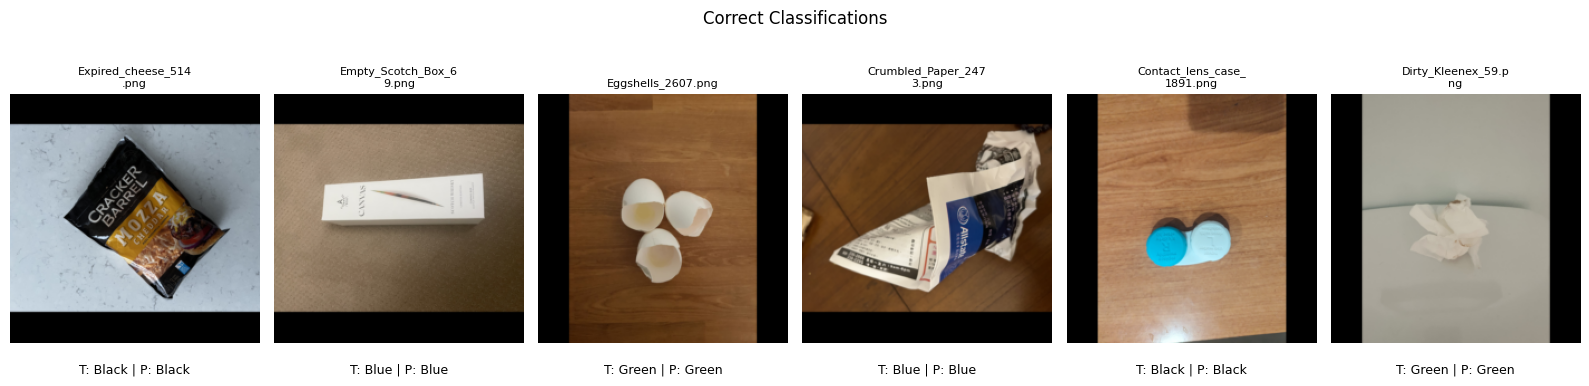

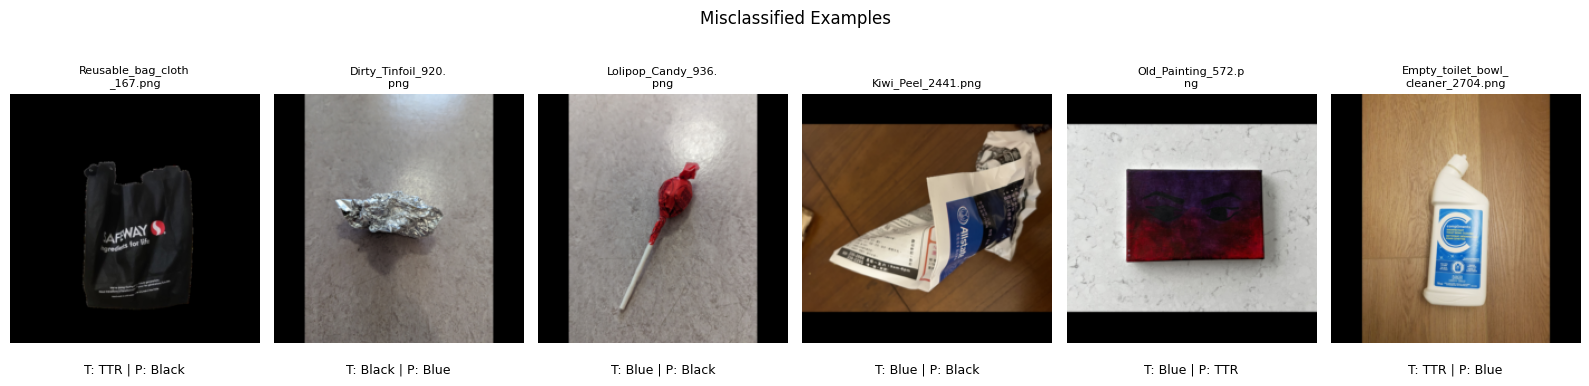

In [49]:
# === Plotting Correct and Incorrect Classification Examples ===

# Function to reverse ImageNet normalization for visualization
def unnormalize(img):
    """
    Undo ImageNet normalization so images can be displayed correctly.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean


def plot_examples(example_list, class_names, title, n=6):
    """
    example_list: list of stored samples (img_tensor, true_idx, pred_idx, filepath)
    class_names: list of class labels
    title: figure title
    n: number of examples to display
    """

    if len(example_list) == 0:
        print(f"No examples available for: {title}")
        return

    # Randomly sample up to n examples
    samples = random.sample(example_list, k=min(n, len(example_list)))

    plt.figure(figsize=(16, 4))

    for i, (img, t, p, path) in enumerate(samples, 1):
        ax = plt.subplot(1, len(samples), i)

        # Unnormalize and convert from (C,H,W) → (H,W,C)
        img_vis = unnormalize(img).permute(1, 2, 0).clamp(0, 1)
        ax.imshow(img_vis)
        ax.axis("off")

        # Display filename (wrapped for readability)
        fname = os.path.basename(path)
        fname = "\n".join(textwrap.wrap(fname, width=18))

        ax.text(0.5, 1.02, fname,
                ha="center", va="bottom",
                transform=ax.transAxes, fontsize=8)

        # Show true vs predicted label
        ax.text(0.5, -0.08,
                f"T: {class_names[t]} | P: {class_names[p]}",
                ha="center", va="top",
                transform=ax.transAxes, fontsize=9)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



# ---- Plot Correct Examples ----
plot_examples(correct, class_names,
              title="Correct Classifications",
              n=6)

# ---- Plot Misclassified Examples ----
plot_examples(wrong, class_names,
              title="Misclassified Examples",
              n=6)

Above are some samples output by the network. It appears that the most common misclassification is between the Black and Blue class, followed by misclassifying TTR items as Black. Often times, these are difficult to distinguish.

A sample output is shown below. The Empty_toilet_bowl_cleaner_2704.png is a good example of a difficult to classify item. Externally, this looks like a plastic container, the name does not suggest anything different, especially given that the term "empty" is likely often used for many items that truly do go into the blue bin. The term "cleaner" could be the indicator as to not place this item into the Blue bin, however it is likely that there were not many "cleaner"s in the training set for the network to extract this feature.

This example also shows that there is a fair amount of mislabelling occuring within the data. The central 3 images from Lilipop_Candy_936.png to Old_Painting_572.png all appear to be mislabeled:
*    Lolipop_Candy should either go into the green bin if the stem is paper-based, or the black bin if plastic based
*    Kiwi_Peel shows an image of a newspaper in place of a kiwi peel
*    Old_Painting likely should be TTR and not Blue

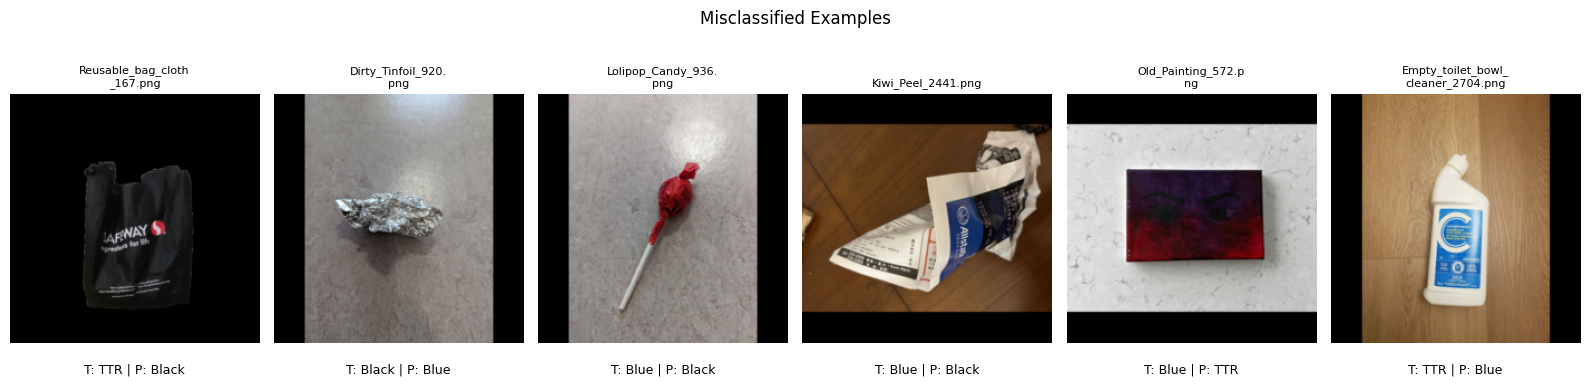

Next we populate the confusion matrix used to visualize the results and use the matrix to determine the overall model accuracy

In [ ]:
# === Populating Confusion Matrix and Overall Model Accuracy ===
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

accuracy = np.trace(cm) / np.sum(cm) # Model accuracy is diagonal count in confusion matrix divided by total
print(f"\nOverall accuracy: {accuracy:.4f}")



Overall accuracy: 0.7969


Overall, the best acheived model accuracy was found to be about 81%

Now we consider the remaining statistical values of:
*   Sensitivity
*   Specificity
*   Precision
*   F1 Score

Per each class and some additional global model metrics

In [36]:
# === Overall and per Class Model Stats ===
eps = 1e-12  # avoid divide-by-zero

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

sensitivity = TP / (TP + FN + eps)      # recall / TPR
specificity = TN / (TN + FP + eps)      # TNR
precision   = TP / (TP + FP + eps)
f1          = 2 * precision * sensitivity / (precision + sensitivity + eps)

print("\nPer-class metrics:")
for i, name in enumerate(class_names):
    print(f"{name:>6} | "
          f"Sens={sensitivity[i]:.3f}  "
          f"Spec={specificity[i]:.3f}  "
          f"Prec={precision[i]:.3f}  "
          f"F1={f1[i]:.3f}  "
          f"Support={cm.sum(axis=1)[i]}")

print("\nMacro averages (mean over classes):")
print(f"Sensitivity (Recall): {sensitivity.mean():.3f}")
print(f"Specificity:          {specificity.mean():.3f}")
print(f"F1:                   {f1.mean():.3f}")



Per-class metrics:
 Black | Sens=0.668  Spec=0.912  Prec=0.658  F1=0.663  Support=695
  Blue | Sens=0.797  Spec=0.913  Prec=0.808  F1=0.802  Support=1086
 Green | Sens=0.911  Spec=0.962  Prec=0.879  F1=0.895  Support=799
   TTR | Sens=0.796  Spec=0.941  Prec=0.818  F1=0.807  Support=852

Macro averages (mean over classes):
Sensitivity (Recall): 0.793
Specificity:          0.932
F1:                   0.792


The Green class exhibits the strongest performance across all metrics, with the highest sensitivity, specificity, and F1-score. This indicates that Green items are both reliably detected and rarely confused with other categories, suggesting strong separability in the learned feature space.

In contrast, the Black class demonstrates the weakest performance, with the lowest sensitivity and precision. This implies both frequent misclassification of true Black items and substantial confusion from other classes being predicted as Black. The relatively poor separability of this class suggests significant feature overlap with other waste categories.

The Blue class exhibits moderate recall and precision, indicating that a meaningful fraction of Blue items are confused with other categories, though predictions labeled as Blue are generally reliable.

The TTR class, while not the weakest performer, may act as a semantically broad category. Given the heterogeneous nature of items assigned to TTR, the network may map uncertain samples into this class when decision boundaries between other categories are ambiguous.

Notably, the confusion patterns reflect intuitive human difficulty in waste sorting, where certain categories (e.g., Green) are visually well-defined, while others (particularly Black) exhibit greater ambiguity.

Finally, we move onto plotting the confusion matrix.

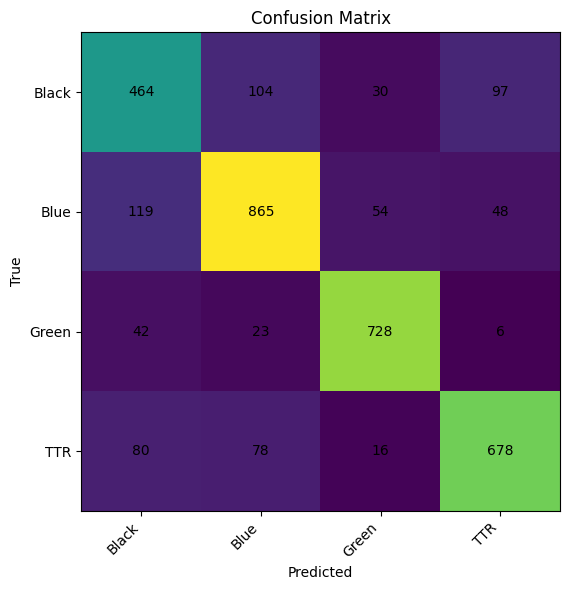

In [ ]:
# === Plotting Confusion Matrix ===

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

# annotate counts
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


The confusion matrix highlights clear differences in class separability. The Green class appears to be the most distinct category, with the majority of Green samples correctly classified and comparatively few being assigned to other classes. This indicates that the model has learned strong visual and/or semantic features that reliably distinguish Green items from the rest.

In contrast, the most significant confusion occurs between the Black and Blue classes. There is a pronounced bidirectional mix-up between these two categories, with many Black items predicted as Blue and many Blue items predicted as Black. This mutual confusion suggests substantial feature overlap in the learned representation. The items in these classes may share similar textures, materials, or visual characteristics, and their associated textual features may not provide sufficiently discriminative information. As a result, the decision boundary between Black and Blue appears less well-defined than for other class pairs.

The TTR class exhibits moderate confusion with multiple other categories, which is consistent with its role as a broad or heterogeneous class. Because TTR may contain a wide variety of visually dissimilar items, the model can occasionally map ambiguous samples into or out of this category. However, confusion between TTR and Green appears comparatively limited, further reinforcing the distinctiveness of the Green class.

Overall, the confusion matrix suggests that while the model performs strongly on well-separated categories, it struggles with classes that share overlapping visual or semantic characteristics—particularly Black and Blue. This indicates that further improvements may require more discriminative features, additional training samples, or refined class definitions to better separate these overlapping categories.